<img src="https://cdn.siberian.dev/siberian.png" alt="Siberian Logo">

### Clustering Based Local Outlier Factor With RobustScaler

This code template is for Anomaly detection or outlier analysis using the Clustering Based Local Outlier Factor(CBLOF) Algorithm. The demonstration also illustrates data rescaling using RobustScaler.

### Required Packages

In [ ]:
!pip install plotly
!pip install pyod

In [2]:
import time
import warnings
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from pyod.models.cblof import CBLOF
from sklearn.preprocessing import LabelEncoder,RobustScaler 
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

### Initialization

Filepath of CSV file

In [3]:
file_path= ''

List of features which are  required for model training .

In [4]:
features=[]

### Data Fetching

Pandas is an open-source, BSD-licensed library providing high-performance, easy-to-use data manipulation and data analysis tools.

We will use panda's library to read the CSV file using its storage path.And we use the head function to display the initial row or entry.

In [5]:
df=pd.read_csv(file_path)
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


### Feature Selections

It is the process of reducing the number of input variables when developing a predictive model. Used to reduce the number of input variables to both reduce the computational cost of modelling and, in some cases, to improve the performance of the model.

We will assign all the required input features to X.

In [7]:
X=df[features]

### Data Preprocessing

Since the majority of the machine learning models in the Sklearn library doesn't handle string category data and Null value, we have to explicitly remove or replace null values. The below snippet have functions, which removes the null value if any exists. And convert the string classes data in the datasets by encoding them to integer classes.

In [8]:
def NullClearner(df):
    if(isinstance(df, pd.Series) and (df.dtype in ["float64","int64"])):
        df.fillna(df.mean(),inplace=True)
        return df
    elif(isinstance(df, pd.Series)):
        df.fillna(df.mode()[0],inplace=True)
        return df
    else:return df
def EncodeX(df):
    return pd.get_dummies(df)

Calling preprocessing functions on the feature set.


In [9]:
x=X.columns.to_list()
for i in x:
    X[i]=NullClearner(X[i])  
X=EncodeX(X)
X.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male
0,68.95,35,61833.90,256.09,0
1,80.23,31,68441.85,193.77,1
2,69.47,26,59785.94,236.50,0
3,74.15,29,54806.18,245.89,1
4,68.37,35,73889.99,225.58,0



###Rescaling technique
####Robust Scaler

Standardization of a dataset is a common requirement for many machine learning estimators. Typically this is done by removing the mean and scaling to unit variance. However, outliers can often influence the sample mean / variance in a negative way. In such cases, the median and the interquartile range often give better results.

The Robust Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).


In [10]:
X_Scaled=RobustScaler().fit_transform(X)
X_Scaled=pd.DataFrame(data = X_Scaled,columns = X.columns)
X_Scaled.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male
0,0.027034,0.000000,0.261492,0.912428,0.0
1,0.441931,-0.307692,0.619863,0.133062,1.0
2,0.046161,-0.692308,0.150424,0.667438,0.0
3,0.218299,-0.461538,-0.119645,0.784868,1.0
4,0.005701,0.000000,0.915334,0.530874,0.0


### Data Splitting

The train-test split is a procedure for evaluating the performance of an algorithm. The procedure involves taking a dataset and dividing it into two subsets. The first subset is utilized to fit/train the model. The second subset is used for prediction. The main motive is to estimate the performance of the model on new data.

In [11]:
x_train,x_test=train_test_split(X,test_size=0.2,random_state=123)

### Model
Used pyod.models.cblof module

The CBLOF operator calculates the outlier score based on cluster-based local outlier factor.

CBLOF takes as an input the data set and the cluster model that was generated by a clustering algorithm. It classifies the clusters into small clusters and large clusters using the parameters alpha and beta. The anomaly score is then calculated based on the size of the cluster the point belongs to as well as the distance to the nearest large cluster.

Read more at [pyod.readthedocs.io](https://pyod.readthedocs.io/en/latest/_modules/pyod/models/cblof.html)

In [12]:
model = CBLOF(contamination=0.001,n_jobs=-1)
model.fit(x_train)

CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.001, n_clusters=8, n_jobs=-1, random_state=None,
   use_weights=False)

### Anomaly Prediction

In [13]:
result=x_test.copy(deep=True)
result['Anomaly']=model.predict(x_test)
result.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Anomaly
131,41.67,36,53817.02,132.55,0,0
203,70.04,31,74780.74,183.85,1,0
50,73.18,23,61526.25,196.71,1,0
585,78.60,46,41768.13,254.59,1,0
138,71.89,23,61617.98,172.81,1,0


### Anomaly Visualization

#### Bar Plot

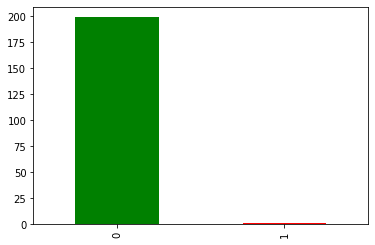

In [14]:
result['Anomaly'].value_counts().plot(kind='bar',color=['green','red'])

#### Pie Chart

In [15]:
fig = px.pie(result['Anomaly'],names=result['Anomaly'], title='Anomaly rate',)
fig.show()

#### Anomalies

In this part we will perform Dimensionality Reduction technique to visualize data. This can be performed using technique such as PCA or TSNE algorithms.

In [16]:
pca = PCA(n_components=2)
pca_results = pca.fit_transform(result.drop('Anomaly',axis=1))

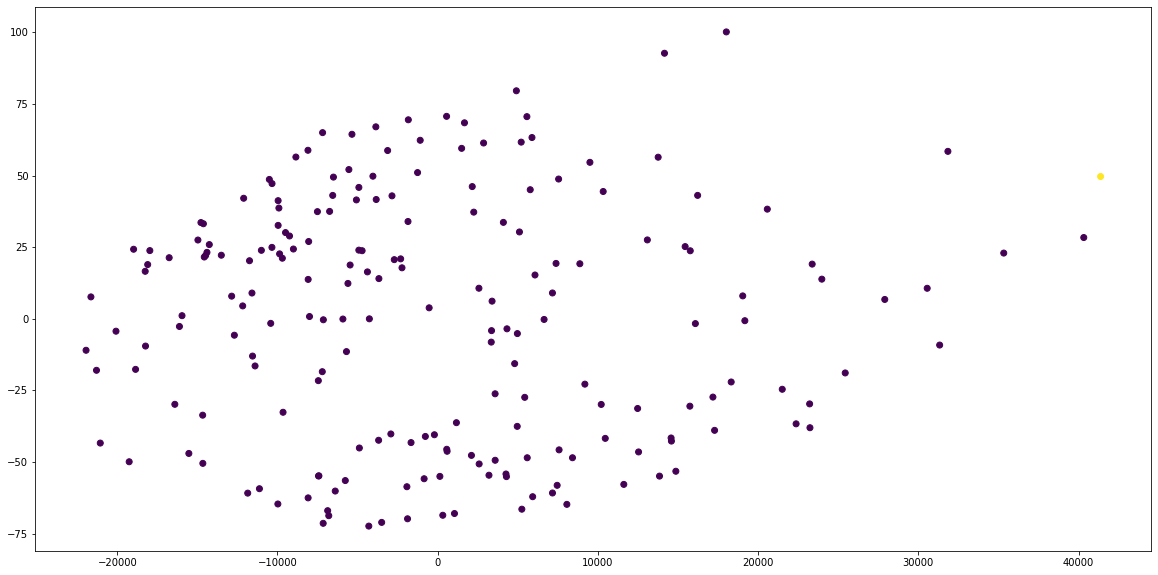

In [17]:
plt.rcParams["figure.figsize"] = (20,10)
plt.scatter(x=pca_results[:,0],y=pca_results[:,1],c=result.iloc[:,result.columns.get_loc('Anomaly')])
plt.show()

#### Creator: Arpit Somani, Github: [Profile](https://github.com/arpitsomani8)